# Learner selection

Having analysed and modelled coffee data, it is time to select the approriate Learner for it. 

**Learning objective:** From my analysis I want to select learner, which will most accuratelly fit the data and predict brewing method, focusing on avoiding false positive (could be brand damaging to the client), but also considering false negative (not to miss out on cheaper raw materials).


To chose the learner I take into cosideration the following factors: all my data is labelled categorical text data, and I have only 851 samples after data cleaning and removal of outliers.

Because of categorical text data I will also test *Naive Bayes*, which works well with small training data, also it is good for combating the curse of dimensionality (though it does not seem to be the problem in my dataset).
Another Classifier I will try is the *KNN*, which works well where the decision boundry is very irregular.
Finally, I am considering *Decistion Trees*, however, their implemention in sklear requires numerical data only, and I will have to encode all of my text variables.

My initial assumption is that Naive Bayes will best correspond to my data, and the problem I am trying to solve.

## Data split

Before I can start testing learners, I need to split my data. I will use random seed 42, to make sure I always get the same randomly divided data.

In [172]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [173]:
coffee_df = pd.read_csv('data\coffee_desk_dataset_ead_selected.csv', index_col=0)
coffee_df.head(5)

,origin_region,natural,fermented_traditional,fermented_closed_tank,brewing_method_binary_num
idx,,,,,
1,Latam,True,False,False,1
2,Africa,True,False,False,1
3,Africa,False,False,False,1
4,Asia,True,False,False,1
5,Latam,True,False,False,1


In [174]:
X_df = coffee_df.drop('brewing_method_binary_num', axis=1) # defining predictors
y_df = coffee_df['brewing_method_binary_num'] # defining target variable

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42) #using random state to ensure I always have random division with the same random numbers
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Data encoding

Since my data is categorical text data, I will encode it with one hot encoder into binary vectors.

In [176]:
from sklearn.preprocessing import OneHotEncoder

In [178]:
encoder = OneHotEncoder(handle_unknown="ignore")
encoder.fit(X_train) # all variables are categorical

OneHotEncoder(handle_unknown='ignore')

In [179]:
X_train = encoder.transform(X_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

## Model selection

Having encoded data (target is already encoded as 1 for specialty brewing and 0 for espresso), I can now proceed to fit different models on my data, and decide which to use as the optimal with possible changes to optimazation and hyperparameters.

In [180]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [181]:
# I need to convert my X dataset into dense array
X_train_dense = X_train.todense()
X_validation_dense = X_validation.todense()

Now, I try all 3 chosen learners and I will apply to AUC score to decide which will be the best for my data. First, I am saving predictions for both validation and train sets to also see if there is no overfitting.

In [182]:
models = {
    'CategoricalBayes' : CategoricalNB(),
    'DecisionTree' : DecisionTreeClassifier(random_state=42),
    'KNNs' : KNeighborsClassifier(n_neighbors=9) # for forced proba it will give 50%
}

train_predictions_by_model = {}
validation_predictions_by_model = {}

for name, model in models.items():

    model.fit(X_train_dense, y_train)

    y_train_pred = model.predict_proba(X_train_dense)
    y_validation_pred = model.predict_proba(X_validation_dense)

    train_predictions_by_model[name] = y_train_pred
    validation_predictions_by_model[name] = y_validation_pred

In [183]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_score
import numpy as np

In [184]:
for name, predicted_proba in train_predictions_by_model.items():
    score = roc_auc_score(y_train, predicted_proba[:,1])
    print(f'{name} has AUC score of {score}')

CategoricalBayes has AUC score of 0.7702828263531291
DecisionTree has AUC score of 0.8117298691374534
KNNs has AUC score of 0.7269861669517798


**Decision Tree Classifier** has the highest AUC score, however, I still need to check the validation set to make sure this is not due to overfitting.

In [185]:
for name, predicted_proba in validation_predictions_by_model.items():
    score = roc_auc_score(y_validation, predicted_proba[:,1])
    print(f'{name} has AUC score of {score}')

CategoricalBayes has AUC score of 0.790420819490587
DecisionTree has AUC score of 0.837486157253599
KNNs has AUC score of 0.6893687707641196


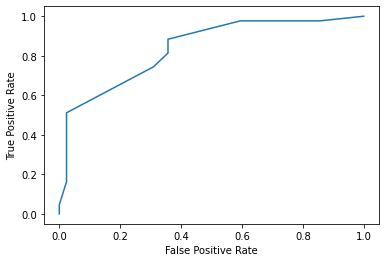

In [186]:
y_val_pred_proba = validation_predictions_by_model['DecisionTree']
fpr, tpr, threshold = roc_curve(y_validation, y_val_pred_proba[:,1], pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [187]:
import fm_optim as fmo #importing the self defined library with methods for fm optimization

In [188]:
condition_positive = y_df.sum() #The other class is labelled as 0, hence it will not be summed
total_population = y_df.shape[0]
prevalence = fmo.calculate_prevalence(condition_positive, total_population)
prevalence

0.5334900117508813

Now, that I have calculated prevalence (ratio of positive class (special brewing) to the total population), I need to establish the cost of commiting type I error: false positive (espresso disguised as specialty brewing) and type II error: false negative (specialty brewing rejected as espresso).
Having done research in the subject of financial gains and losses I have assumed 18 (GBP) loss for false negative, and 30 (GBP) loss for false positive.
False negative will simply mean missing cheaper raw material, and given that the chepeast specialty coffee cost o avg. 36 GBP per kg, while more expensive specialy coffee cost approx 72 GBP per kg, and a 1 kg pack serves 120-140 cups, assuming half pack usage per day, daily loss would amount to 18 GBP.
At the same time, on average a client spends 10 GBP daily (coffee and possibly some snacks), and assuming unhappy client would spread the bad word to 3 people, it would amount to up to 30 GBP daily loss per client. Naturally, bad opinion can extend with time, or be reversed with appropriate measure taken. Nevertheless, **for the purpose of present modelling I set the costs as follow:**
- cost of false positive = 30
- cost of false negative = 18

In [189]:
cost_fp = 30
cost_fn = 18
m_factor = fmo.calculate_m_factor(prevalence, cost_negative=cost_fn, cost_positive=cost_fp)
fm = fmo.calculate_fm(tpr, fpr, m_factor)
highest_fm = np.argmax(fm)
best_threshold = round(threshold[highest_fm],2)
print(f'Best threshold is {best_threshold}')

Best threshold is 0.5


Having chosen the best threshold as per the fm optimization above, I can now predict labels with Decision Tree classifier and then test the model to see how it might perform on production data.

In [190]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_dense, y_train)

y_train_pred = (model.predict_proba(X_train)[:,1] >= best_threshold).astype(bool)
y_validation_pred = (model.predict_proba(X_validation)[:,1] >= best_threshold).astype(bool)
y_test_pred = (model.predict_proba(X_test)[:,1] >= best_threshold).astype(bool)

Positive predictive value is 0.71


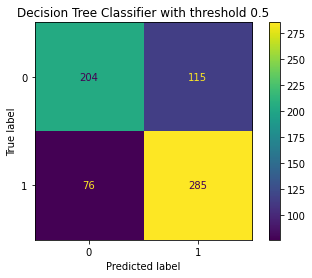

In [222]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cm.ravel()
display = ConfusionMatrixDisplay(cm).plot()
display.ax_.set_title(f'Decision Tree Classifier with threshold {best_threshold}')
ppv = round(precision_score(y_train, y_train_pred),2)
print(f'Positive predictive value is {ppv}')

Positive predictive value is 0.72


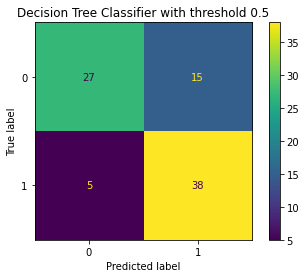

In [223]:
cm = confusion_matrix(y_validation, y_validation_pred)
display = ConfusionMatrixDisplay(cm).plot()
display.ax_.set_title(f'Decision Tree Classifier with threshold {best_threshold}')
ppv = round(precision_score(y_validation, y_validation_pred),2)
print(f'Positive predictive value is {ppv}')

Positive predictive value is 0.73


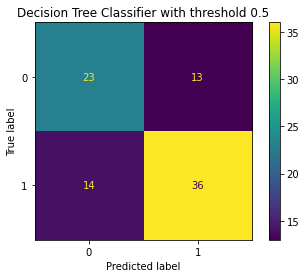

In [194]:
cm = confusion_matrix(y_test, y_test_pred)
display = ConfusionMatrixDisplay(cm).plot()
display.ax_.set_title(f'Decision Tree Classifier with threshold {best_threshold}')
ppv = round(precision_score(y_test, y_test_pred),2)
print(f'Positive predictive value is {ppv}')

The result means that there is approx. 72% certainity that when the client selects coffee beans as per model, they will be good for specialty brewing. This is a bit small degree of certainity, and still risks the brand damaging consequences.

## Some tests with Decision Tree hyperparams

Positive predictive value is 0.71


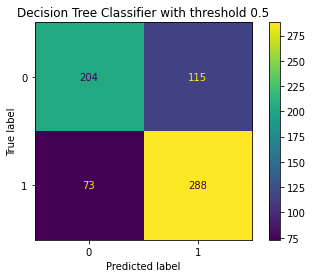

In [224]:
model = DecisionTreeClassifier(random_state=42, min_samples_split=10)
model.fit(X_train_dense, y_train)

y_train_pred = (model.predict_proba(X_train)[:,1] >= best_threshold).astype(bool)
cm = confusion_matrix(y_train, y_train_pred)
display = ConfusionMatrixDisplay(cm).plot()
display.ax_.set_title(f'Decision Tree Classifier with threshold {best_threshold}')
ppv = round(precision_score(y_train, y_train_pred),2)
print(f'Positive predictive value is {ppv}')

Positive predictive value is 0.72


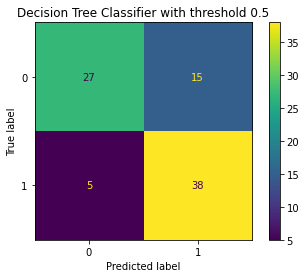

In [225]:
y_val_pred = (model.predict_proba(X_validation)[:,1] >= best_threshold).astype(bool)

cm = confusion_matrix(y_validation, y_validation_pred)
display = ConfusionMatrixDisplay(cm).plot()
display.ax_.set_title(f'Decision Tree Classifier with threshold {best_threshold}')
ppv = round(precision_score(y_validation, y_validation_pred),2)
print(f'Positive predictive value is {ppv}')

Positive predictive value is 0.71


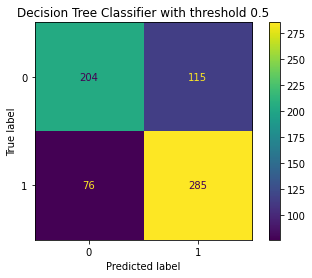

In [226]:
model = DecisionTreeClassifier(random_state=42, min_samples_leaf=10)
model.fit(X_train_dense, y_train)

y_train_pred = (model.predict_proba(X_train)[:,1] >= best_threshold).astype(bool)
cm = confusion_matrix(y_train, y_train_pred)
display = ConfusionMatrixDisplay(cm).plot()
display.ax_.set_title(f'Decision Tree Classifier with threshold {best_threshold}')
ppv = round(precision_score(y_train, y_train_pred),2)
print(f'Positive predictive value is {ppv}')

Positive predictive value is 0.72


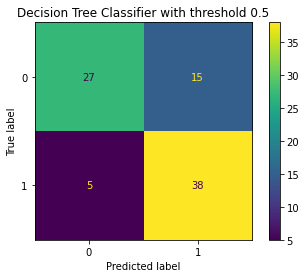

In [227]:
y_val_pred = (model.predict_proba(X_validation)[:,1] >= best_threshold).astype(bool)

cm = confusion_matrix(y_validation, y_validation_pred)
display = ConfusionMatrixDisplay(cm).plot()
display.ax_.set_title(f'Decision Tree Classifier with threshold {best_threshold}')
ppv = round(precision_score(y_validation, y_validation_pred),2)
print(f'Positive predictive value is {ppv}')

Positive predictive value is 0.71


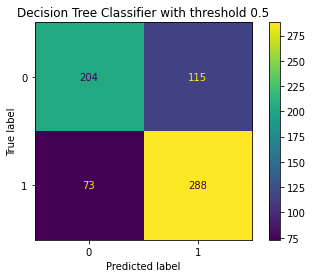

In [228]:
model = DecisionTreeClassifier(random_state=42, criterion="entropy")
model.fit(X_train_dense, y_train)

y_train_pred = (model.predict_proba(X_train)[:,1] >= best_threshold).astype(bool)
cm = confusion_matrix(y_train, y_train_pred)
display = ConfusionMatrixDisplay(cm).plot()
display.ax_.set_title(f'Decision Tree Classifier with threshold {best_threshold}')
ppv = round(precision_score(y_train, y_train_pred),2)
print(f'Positive predictive value is {ppv}')

Positive predictive value is 0.72


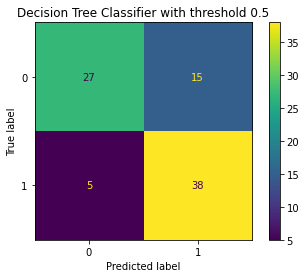

In [229]:
y_val_pred = (model.predict_proba(X_validation)[:,1] >= best_threshold).astype(bool)

cm = confusion_matrix(y_validation, y_validation_pred)
display = ConfusionMatrixDisplay(cm).plot()
display.ax_.set_title(f'Decision Tree Classifier with threshold {best_threshold}')
ppv = round(precision_score(y_validation, y_validation_pred),2)
print(f'Positive predictive value is {ppv}')

Positive predictive value is 0.74


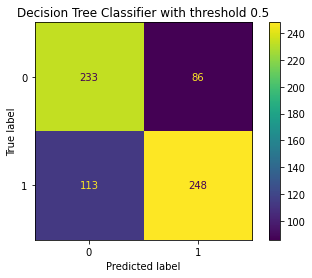

In [209]:
model = DecisionTreeClassifier(random_state=42, max_depth=3)
model.fit(X_train_dense, y_train)

y_train_pred = (model.predict_proba(X_train)[:,1] >= best_threshold).astype(bool)
cm = confusion_matrix(y_train, y_train_pred)
display = ConfusionMatrixDisplay(cm).plot()
display.ax_.set_title(f'Decision Tree Classifier with threshold {best_threshold}')
ppv = round(precision_score(y_train, y_train_pred),2)
print(f'Positive predictive value is {ppv}')

Positive predictive value is 0.72


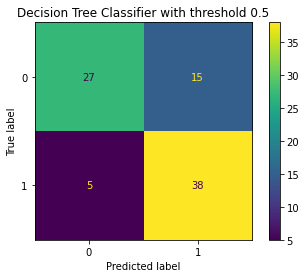

In [210]:
y_val_pred = (model.predict_proba(X_validation)[:,1] >= best_threshold).astype(bool)

cm = confusion_matrix(y_validation, y_validation_pred)
display = ConfusionMatrixDisplay(cm).plot()
display.ax_.set_title(f'Decision Tree Classifier with threshold {best_threshold}')
ppv = round(precision_score(y_validation, y_validation_pred),2)
print(f'Positive predictive value is {ppv}')

Positive predictive value is 0.79


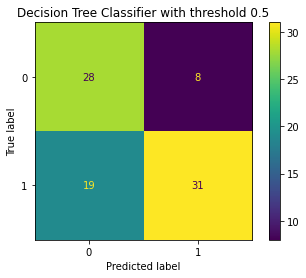

In [211]:
y_test_pred = (model.predict_proba(X_test)[:,1] >= best_threshold).astype(bool)

cm = confusion_matrix(y_test, y_test_pred)
display = ConfusionMatrixDisplay(cm).plot()
display.ax_.set_title(f'Decision Tree Classifier with threshold {best_threshold}')
ppv = round(precision_score(y_test, y_test_pred),2)
print(f'Positive predictive value is {ppv}')

Some checks with different hyperparameters on Decision tree show, that setting max depth of the tree to 3 improved the training score to 74% for PPV, however, the validation remained the same. Interestingly, the score was much higher with test (79%) but this could simply be due to randomness in data, and test cannot be taken to optimize model. It's only an interesting observation on how the model generalizes.

## RESULTS AND RECOMMENDATIONS:
* model did slightly better on validation set than training set - randomness of data
* the precision score was decent but not high enough to yield satisfactory performance for the coffee purchasing process
* two variables: roast and blend are enough to distinguish specialist beans without implementing AI solutions
* **Final recommendation:** invest in new beans rather than advance AI system 